In [56]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plot

In [104]:
IMG_PATH = ['images/TS-027.png', 'images/TS-028.png', 'images/TS-029.png', 'images/TS-030.png']
RATIO = 0.5
RANSAC_THRESHOLD = 4

In [79]:
def load_images(img_paths):
    images = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

In [80]:
def view_images(images):
    # Now view/plot the images
    n = len(images)
    cols = 2
    rows = (n // cols) + (n % cols > 0)
    plot.figure(figsize=(16, 9))
    for i in range(n):
        plot.subplot(rows, cols, i + 1)
        plot.imshow(images[i])
        plot.axis('off')
        plot.title("Image " + str(i+1))
    plot.show()

In [97]:
def get_SIFT_keypoints(img1, img2):
    descriptor = cv2.SIFT_create()
    kp1, desc1 = descriptor.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, desc2 = descriptor.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)

    # display the keypoints and features detected on both images
    fig, (ax1, ax2) = plot.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    ax1.imshow(cv2.drawKeypoints(img1, kp1, None, color=(0,255,0)))
    ax1.set_title("Source image keypoints")
    ax1.axis('off')
    
    ax2.imshow(cv2.drawKeypoints(img2, kp2, None, color=(0,255,0)))
    ax2.set_title("Stitching image keypoints")
    ax2.axis('off')
    
    plot.show()

    return (kp1, kp2, desc1, desc2)

In [99]:
def get_matches(img1, img2, kp1, kp2, desc1, desc2):
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(desc2, desc1, k=2)

    # ratio test
    good = []
    for m in matches:
        if m[0].distance < m[1].distance * RATIO:
            good.append(m[0])

    fig =  plot.figure(figsize=(20,8))
    mapped_features_image = cv2.drawMatches(img1, kp1, img2, kp2, good[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plot.axis('off')
    plot.title("Brute force matches")
    plot.imshow(mapped_features_image)

    return good

In [83]:
def get_homography_matrix(matches, kp1, kp2):
    if len(matches) < 4:
        raise ValueError("Not enough keypoints")
    else:
        pts1 = np.float32([kp1[m.trainIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.queryIdx].pt for m in matches])
        
        H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC, RANSAC_THRESHOLD)
        return H

In [84]:
def calculate_bounding_box(img, H):
    h, w = img.shape[:2]
    corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, H)
    x_coords, y_coords = zip(*transformed_corners.reshape(4, 2))
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    return min_x, min_y, max_x, max_y

In [85]:
def stitch_images(img1, img2, H):
    min_x1, min_y1, max_x1, max_y1 = calculate_bounding_box(img1, np.eye(3))
    min_x2, min_y2, max_x2, max_y2 = calculate_bounding_box(img2, H)
    
    min_x = min(min_x1, min_x2)
    min_y = min(min_y1, min_y2)
    max_x = max(max_x1, max_x2)
    max_y = max(max_y1, max_y2)
    
    translation = np.array([[1, 0, -min_x],
                            [0, 1, -min_y],
                            [0, 0, 1]])
    
    H_translation = translation @ H
    stitched_img = cv2.warpPerspective(img2, H_translation, (int(max_x - min_x), int(max_y - min_y)))
    stitched_img[-int(min_y1):int(max_y1 - min_y1), -int(min_x1):int(max_x1 - min_x1)] = img1
    return stitched_img

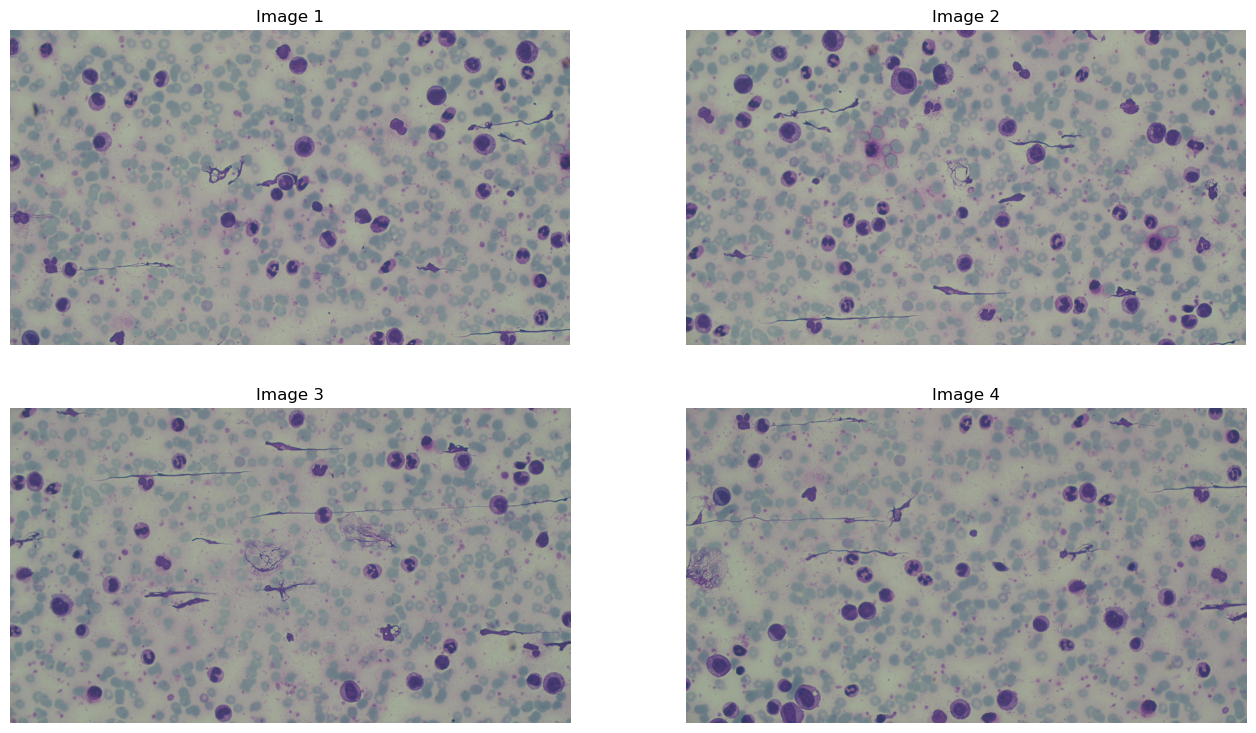

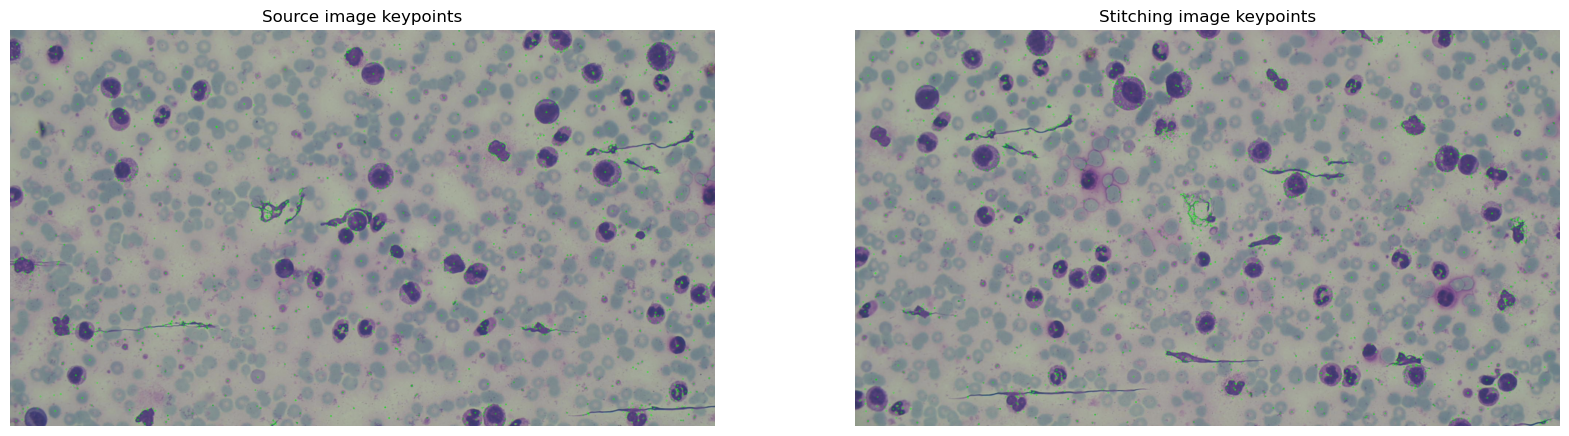

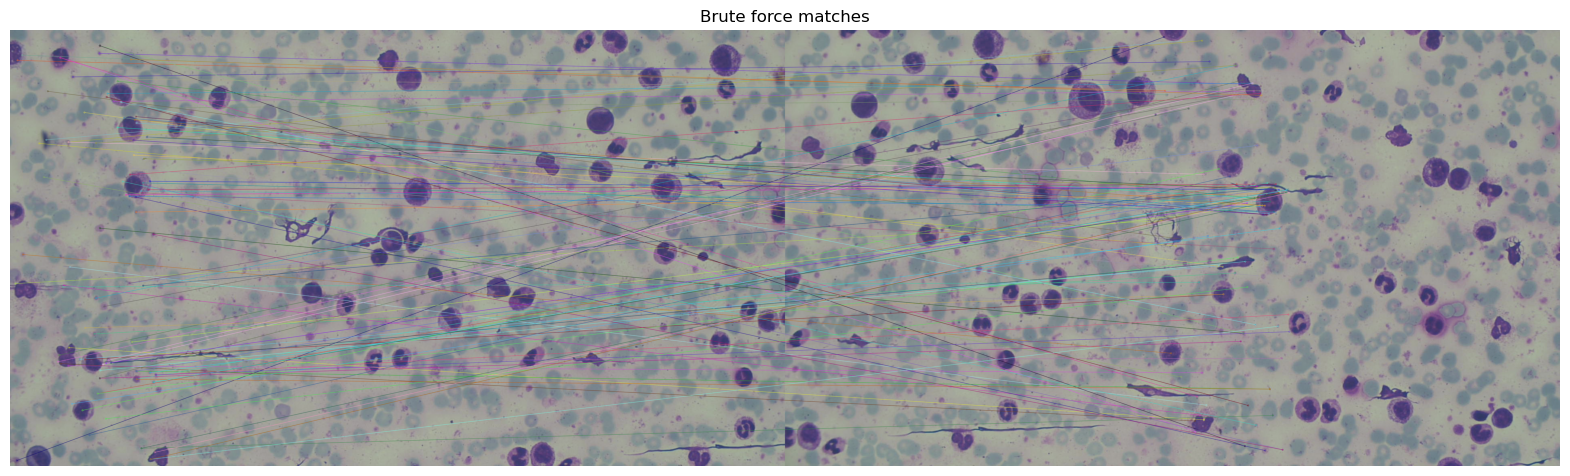

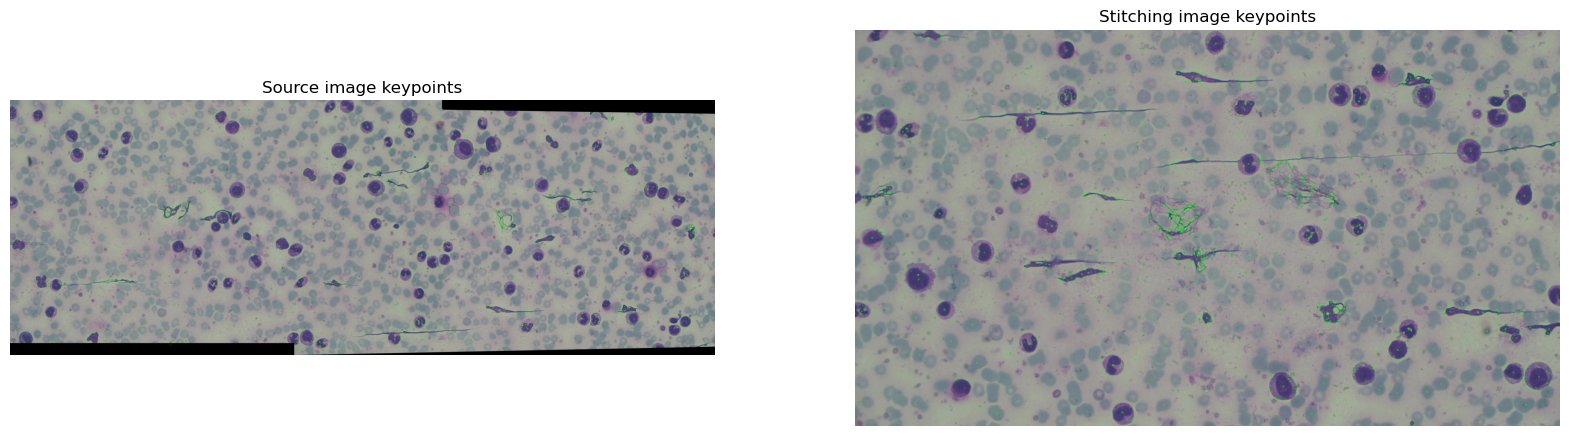

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\features2d\src\draw.cpp:242: error: (-215:Assertion failed) i2 >= 0 && i2 < static_cast<int>(keypoints2.size()) in function 'cv::drawMatches'


<Figure size 2000x800 with 0 Axes>

In [105]:
# load images
images = load_images(IMG_PATH)

# Now view/plot the images
view_images(images)

stitched_img = images[0]
for i in range(1, len(images)):
    # getting SIFT keypoints and descriptors
    kp1, kp2, desc1, desc2 = get_SIFT_keypoints(stitched_img, images[i])
    
    # finding matches using brute force method
    matches = get_matches(stitched_img, images[i], kp1, kp2, desc1, desc2)

    # finding homography matrix
    H = get_homography_matrix(matches, kp1, kp2)
    
    # stitching image
    stitched_img = stitch_images(stitched_img, images[i], H)

plot.figure(figsize=(20,10))
plot.axis('off')
plot.imshow(stitched_img)
plot.title("Final Stitched Image")
plot.show()

# cv2.imwrite('stitched_img.jpg', stitched_img)

## GROUND TRUTH FOR REFERENCE

![Image Description](gt.png)


In [65]:
# TODO: 
# calculate height, width dynamically based on warped image
# dynamically find a center point to anchor the source image
# visualize keypoints matching vertically if images are stitched together
# make proper functions 
# the stitched image can be used as source image to stitch the third incoming image 